# **Setup**

## 1) Loading Data and Packages

In [55]:
import os
from google.colab import files
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Load data from local folder

In [56]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv
Saving adh.csv to adh.csv


Setup fitbit_data

In [57]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')

In [58]:
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')

In [59]:
adh_data = pd.read_csv('/content/data/adh.csv')

In [60]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']

## 2) Analyzing + Transforming Data

Preliminary setup

In [52]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_cols:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[result_col] = fitbit_data[result_col].fillna(0)
all_fitbit_data[result_col] = all_fitbit_data[result_col].fillna(0)

One hot encode

In [53]:
# One hot encode
fitbit_data = pd.get_dummies(
    fitbit_data,
    columns=survey_cols,
    prefix=[col + '_response' for col in survey_cols],
    dummy_na=True,
    dtype=float
)

all_fitbit_data = pd.get_dummies(
    all_fitbit_data,
    columns=survey_cols,
    prefix=[col + '_response' for col in survey_cols],
    dummy_na=True,
    dtype=float
)

In [42]:
fitbit_data_w_visits = fitbit_data[fitbit_data['visit_day'] == 1].reset_index(drop=True)
fitbit_data_w_visits

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,921,2021-08-31,App Money,7,NaN,2305.0,102.0,2609.0,462.0,46.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,950,2021-09-29,App Money,7,NaN,1898.0,NaN,915.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,959,2021-10-08,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,991,2021-11-09,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1020,2021-12-08,App Money,7,NaN,2379.0,96.0,2210.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,40015,2024-05-26,No App,272,NaN,1055.0,NaN,802.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
76,40024,2024-06-04,No App,272,NaN,1832.0,88.0,14633.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77,41361,2024-09-19,App Money,279,161.819108,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
78,41632,2024-07-07,App Money,284,241.626352,2584.0,76.0,2694.0,122.0,17.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
(all_fitbit_data.isna().sum() / len(all_fitbit_data)).sort_values(ascending=False)

In [ ]:
fitbit_data

In [31]:
fitbit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44820 entries, 0 to 44819
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               44820 non-null  int64         
 1   date                     44820 non-null  datetime64[ns]
 2   study_group              44820 non-null  object        
 3   fitbit_user_id           44820 non-null  int64         
 4   avgWeight_per_day        32886 non-null  float64       
 5   calories                 41396 non-null  float64       
 6   heart                    34401 non-null  float64       
 7   steps                    41358 non-null  float64       
 8   minutes_asleep           30702 non-null  float64       
 9   minutes_awake            30702 non-null  float64       
 10  days                     44820 non-null  int64         
 11  admit_type               73 non-null     object        
 12  death                    80 non-

In [32]:
fitbit_data.describe()

,Unnamed: 0,date,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,days,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
count,44820.000000,44820,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,30702.000000,30702.000000,44820.000000,...,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000
mean,22409.500000,2023-03-04 14:47:42.650602240,152.518072,189.784778,2235.929534,65.401733,5234.779148,383.079734,54.538662,89.500000,...,0.360018,0.471307,0.004462,0.019835,0.504507,0.471196,0.357854,0.156917,0.014123,0.471107
min,0.000000,2021-07-26 00:00:00,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11204.750000,2022-05-26 00:00:00,80.000000,160.275874,1786.000000,60.000000,2201.000000,317.250000,36.000000,44.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22409.500000,2023-02-16 00:00:00,152.000000,183.644846,2151.500000,64.000000,4441.000000,391.000000,53.000000,89.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33614.250000,2023-11-08 00:00:00,222.000000,211.643520,2557.000000,72.000000,7291.000000,457.000000,70.000000,134.250000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,44819.000000,2025-03-16 00:00:00,307.000000,398.705527,13442.000000,118.000000,37020.000000,1545.000000,435.000000,179.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,12938.563869,NaN,86.485919,45.383202,767.532572,9.289836,4163.937032,126.255121,29.144155,51.961302,...,0.480011,0.499182,0.066652,0.139434,0.499985,0.499175,0.479374,0.363726,0.118000,0.499170


In [33]:
fitbit_data[result_col]

,visit_day
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
44815,0.0
44816,0.0
44817,0.0
44818,0.0


In [34]:
fitbit_data[measure_cols + one_h_feaatures + [result_col]].corr()

,avgWeight_per_day,calories,heart,steps,diet_response_0.0,diet_response_1.0,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan,visit_day
avgWeight_per_day,1.000000,0.373354,0.129531,-0.144976,-0.012775,0.115264,0.037072,-0.116215,0.026173,0.037068,0.100517,-0.116188,0.037277,0.057270,0.128357,-0.115703,0.073727
calories,0.373354,1.000000,-0.023124,0.456305,-0.022520,0.036252,-0.007507,-0.009382,-0.001204,0.008699,0.006654,-0.009054,0.047490,-0.054580,0.015333,-0.009188,0.004931
heart,0.129531,-0.023124,1.000000,-0.173048,-0.033483,0.015795,0.039888,-0.037826,0.033239,0.069086,0.012165,-0.038015,-0.024675,0.060177,0.062618,-0.037960,0.053953
steps,-0.144976,0.456305,-0.173048,1.000000,-0.014462,0.004755,0.038059,-0.035000,-0.014207,-0.012302,0.040083,-0.034741,0.138243,-0.112696,-0.063136,-0.035018,-0.054364
diet_response_0.0,-0.012775,-0.022520,-0.033483,-0.014462,1.000000,-0.075231,-0.143982,-0.181251,0.055853,0.091097,0.148067,-0.181211,0.072133,0.143803,0.028087,-0.180695,-0.031839
diet_response_1.0,0.115264,0.036252,0.015795,0.004755,-0.075231,1.000000,-0.293930,-0.370012,0.027959,0.118060,0.331891,-0.369140,0.259858,0.162634,0.005971,-0.369469,-0.040927
diet_response_2.0,0.037072,-0.007507,0.039888,0.038059,-0.143982,-0.293930,1.000000,-0.708156,0.024406,0.020650,0.697280,-0.707438,0.519989,0.252394,0.102067,-0.707405,-0.069052
diet_response_nan,-0.116215,-0.009382,-0.037826,-0.035000,-0.181251,-0.370012,-0.708156,1.000000,-0.063212,-0.133992,-0.951290,0.998702,-0.703621,-0.406719,-0.112628,0.998702,0.106062
medication_response_0.0,0.026173,-0.001204,0.033239,-0.014207,0.055853,0.027959,0.024406,-0.063212,1.000000,-0.009524,-0.067556,-0.063198,0.010076,0.053948,0.060072,-0.063187,0.017561
medication_response_1.0,0.037068,0.008699,0.069086,-0.012302,0.091097,0.118060,0.020650,-0.133992,-0.009524,1.000000,-0.143542,-0.134282,0.040013,0.120324,0.034505,-0.134258,-0.007367


Missingness in columns

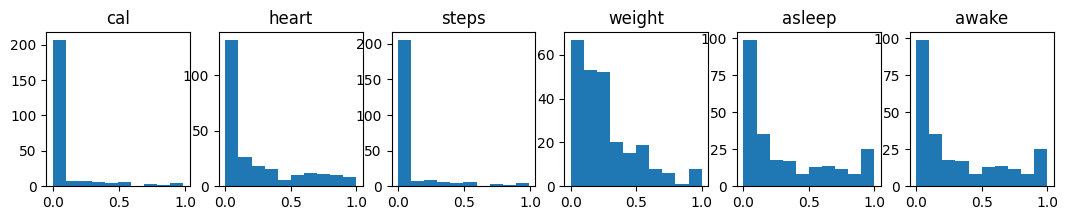

In [62]:
cal = []
heart = []
steps = []
weight = []
asleep = []
awake = []
for i in all_fitbit_data['fitbit_user_id'].unique():
    temp = all_fitbit_data[all_fitbit_data['fitbit_user_id']==i].reset_index(drop=True)
    cal += [temp['calories'].isna().sum()/len(temp)]
    heart += [temp['heart'].isna().sum()/len(temp)]
    steps += [temp['steps'].isna().sum()/len(temp)]
    weight += [temp['avgWeight_per_day'].isna().sum()/len(temp)]
    asleep += [temp['minutes_asleep'].isna().sum()/len(temp)]
    awake += [temp['minutes_awake'].isna().sum()/len(temp)]

fig, axs = plt.subplots(1,6,figsize=(13,2))
axs[0].hist(cal)
axs[0].set_title('cal')
axs[1].hist(heart)
axs[1].set_title('heart')
axs[2].hist(steps)
axs[2].set_title('steps')
axs[3].hist(weight)
axs[3].set_title('weight')
axs[4].hist(asleep)
axs[4].set_title('asleep')
axs[5].hist(awake)
axs[5].set_title('awake')
plt.show()

*   weight, sleep numbers are missing alot

See how many weeks/days should be removed given too many missing values

In [74]:
def windows_to_remove(df, features, max_nans = 3, window_days = 7):

  drop = 0
  count = 0

  for _,group in df.groupby('fitbit_user_id'):
    group = group.copy()

    for i in range(0, len(group), window_days):
      window = group.iloc[i:i+window_days]

      for feature in features:
        nan_count = window[feature].isna().sum()
        if nan_count >= max_nans:
          drop += 1
          break

      count += 1

  keep = count - drop

  return count, keep, drop

count, keep, drop = windows_to_remove(fitbit_data, measure_features)

keep/count

Streaming output truncated to the last 5000 lines.
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105
112
119
126
133
140
147
154
161
168
175
0
7
14
21
28
35
42
49
56
63
70
77
84
91
98
105


0.7567191844300278

## 3) Imputation and Sequence Creation

### 3a) With Imputation

In [ ]:
def determine_visit_label(df, granularity):
    if granularity == 'study':
        return 1 if df['visit_day'].notna().any() else 0
    elif granularity == 'sequence':
        return df['visit_day'].notna().astype(int)
    else:
        raise ValueError("Invalid granularity type")


In [ ]:
# Remove rows that have too many missing values
def mark_day_for_removal(df, cols, max_nans, window):
    df = df.copy()
    df['remove'] = False

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()

        for col in cols:
            n = len(group)
            for start in range(n):
                end = min(start + window, n)
                window_slice = group.iloc[start:end]

                # Count NaNs in this window for this column
                nan_count = window_slice[col].isna().sum()

                if nan_count >= max_nans:
                    # Mark rows with NaN in this column for removal
                    for idx in window_slice.index:
                        if pd.isna(group.at[idx, col]):
                            df.at[idx, 'remove'] = True

    return df

fitbit_data = mark_day_for_removal(fitbit_data, measure_cols+survey_cols, 3, 7)

# Impute columns
def impute_forward_fill(df, cols):
    df = df.copy()
    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        for col in cols:
            group[col] = group[col].ffill()  # forward fill
        df.loc[group.index, cols] = group[cols]
    return df

fb_data = impute_forward_fill(fitbit_data, measure_cols+survey_cols)

# Remove rows with missing values
def final_clean(df, cols):
    df = df.copy()

    # Remove rows marked True in the 'remove' column
    df = df[df['remove'] != True]

    # Remove rows that have any NaN in the specified columns
    df = df.dropna(subset=cols)

    return df

fb_data = final_clean(fb_data, measure_cols+survey_cols)

# Scale numerical columns
scaler = MinMaxScaler().fit(fb_data[measure_cols])
fb_data[measure_cols] = scaler.transform(fb_data[measure_cols])

Creating sequences

In [ ]:
user_ids = fitbit_data['fitbit_user_id'].unique()
train_ids, test_ids = train_test_split(user_ids, test_size=0.2, random_state=42)

train_mask = fitbit_data['fitbit_user_id'].isin(train_ids)
test_mask  = fitbit_data['fitbit_user_id'].isin(test_ids)

sequence_len = 14
feature_cols = measure_cols + survey_cols

def make_sequences(df, user_ids, sequence_len):
    X, y = [], []

    for user_id in user_ids:
        group = df[df['fitbit_user_id'] == user_id].sort_values('date')
        features = group[feature_cols].values
        labels = group['visit_day'].values

        for i in range(len(group) - sequence_len + 1):
            X.append(features[i:i+sequence_len])
            y.append(labels[i + sequence_len - 1])  # label for last day in sequence

    return np.array(X), np.array(y)

# Use split user IDs
X_train, y_train = make_sequences(fitbit_data, train_ids, sequence_len)
X_test,  y_test  = make_sequences(fitbit_data, test_ids,  sequence_len)

In [ ]:
X_train.shape

(33233, 14, 7)